In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
import signal
import numpy as np
import torch
import torch.nn as nn
import torch_optimizer
import matplotlib.pyplot as plt
from time import time
from musicnet_dataset import MusicNet
from musicnet_model import MusicNetModel
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import average_precision_score

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
warnings.filterwarnings("ignore")

N_EPOCHS = 100
EPOCH_SIZE = 2_000
EVAL_SIZE = 1_000
BATCH_SIZE = 4
SMOOTH = 0.1
kwargs = {'pin_memory': True}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

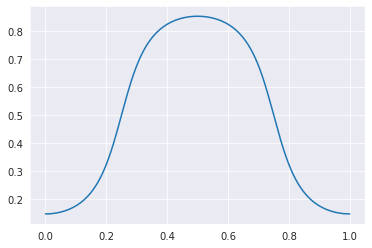

In [4]:
def get_weights(n=2048, delta=0.1):
    xs = np.linspace(-0.25, 0.75, 2048)
    ys = 1 / np.pi * np.arctan(np.sin(2*np.pi*xs) / delta) + 0.5
    return torch.tensor(ys)

plt.plot(np.linspace(0, 1, 2048), get_weights(delta=0.5));

In [5]:
with MusicNet("../data", train=True, download=False, window=8192, epoch_size=EPOCH_SIZE, pitch_shift=64) as train_dataset,\
    MusicNet("../data", train=False, download=False, window=8192, epoch_size=EVAL_SIZE, pitch_shift=64) as test_dataset:

    model = MusicNetModel()
    model.to(device)

    optimizer = torch_optimizer.RAdam(model.parameters(), lr=0.00125*np.sqrt(0.5))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

    loss_fn = nn.BCEWithLogitsLoss(reduction='none', pos_weight=torch.ones([128])*50)
    loss_fn.to(device)

    weights = get_weights(n=2048, delta=0.5).to(device)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True, **kwargs)

    for epoch in range(N_EPOCHS):

        t = tqdm(train_loader, total=EPOCH_SIZE // BATCH_SIZE, desc=f"Train. Epoch {epoch}, loss:")
        losses = []
        model.train()
        for inputs, targets in t:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(-2).to(device))
            targets = targets[:, ::4, :]
            targets = (1 - SMOOTH*2) * targets + SMOOTH  # Label smoothing
            loss = loss_fn(outputs, targets.to(device))
            loss = (loss.permute(0, 2, 1) * weights).mean()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            t.set_description(f"Train. Epoch {epoch}, loss: {np.mean(losses[-100:]):.3f}")
        scheduler.step()

        t = tqdm(test_loader, total=EVAL_SIZE // BATCH_SIZE, desc=f"Validation. Epoch {epoch}.", leave=False)

        all_targets = []
        all_preds = []

        model.eval()
        for inputs, targets in t:
            with torch.no_grad():
                outputs = model(inputs.unsqueeze(-2).to(device))
                outputs = outputs[:, 1024, :].squeeze(1)
                targets = targets[:, 4096, :].squeeze(1)
                all_targets += list(targets.numpy())
                all_preds += list(outputs.detach().cpu().numpy())

        targets_np = np.array(all_targets)
        preds_np = np.array(all_preds)
        mask = targets_np.sum(axis=0) > 0

        print(f"Epoch {epoch}. APS: {average_precision_score(targets_np[:, mask], preds_np[:, mask]) : .2%}.")

Train. Epoch 0, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 0.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 0. APS:  5.02%.


Train. Epoch 1, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 1.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1. APS:  7.35%.


Train. Epoch 2, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 2.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2. APS:  7.56%.


Train. Epoch 3, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 3.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3. APS:  8.27%.


Train. Epoch 4, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 4.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4. APS:  9.29%.


Train. Epoch 5, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 5.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5. APS:  8.81%.


Train. Epoch 6, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 6.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6. APS:  8.99%.


Train. Epoch 7, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 7.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7. APS:  9.28%.


Train. Epoch 8, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 8.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8. APS:  9.08%.


Train. Epoch 9, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 9.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9. APS:  9.00%.


Train. Epoch 10, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 10.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10. APS:  8.08%.


Train. Epoch 11, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 11.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11. APS:  8.91%.


Train. Epoch 12, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 12.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12. APS:  9.03%.


Train. Epoch 13, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 13.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13. APS:  8.58%.


Train. Epoch 14, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 14.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14. APS:  8.86%.


Train. Epoch 15, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 15.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15. APS:  8.79%.


Train. Epoch 16, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 16.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16. APS:  8.65%.


Train. Epoch 17, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 17.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17. APS:  8.89%.


Train. Epoch 18, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 18.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18. APS:  9.10%.


Train. Epoch 19, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 19.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19. APS:  9.13%.


Train. Epoch 20, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 20.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20. APS:  8.62%.


Train. Epoch 21, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 21.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 21. APS:  9.07%.


Train. Epoch 22, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 22.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 22. APS:  8.92%.


Train. Epoch 23, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 23.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 23. APS:  9.22%.


Train. Epoch 24, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 24.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 24. APS:  8.99%.


Train. Epoch 25, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 25.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 25. APS:  8.78%.


Train. Epoch 26, loss::   0%|          | 0/500 [00:00<?, ?it/s]

Validation. Epoch 26.:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 26. APS:  8.31%.


Train. Epoch 27, loss::   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 